## PyData Eindhoven 2020 - Explainable AI Tutorial

Captum website: https://captum.ai/

Algorithms info: https://captum.ai/docs/algorithms

In [125]:
# installing required packages
! pip install captum

# downloading imagenet class index file
! wget -P meta/ https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

# download test images
! wget -P img/ -O img/car.jpg https://www.carscoops.com/wp-content/uploads/2018/03/lamborghini-squadra-corse-huracan-300.jpg
! wget -P img/ -O img/dog.jpg https://www.dogbreedslist.info/uploads/allimg/dog-pictures/Leonberger-3.jpg
! wget -P img/ -O img/cat.jpg http://4.bp.blogspot.com/-bD3QjwYaRds/T9xVNIEsy0I/AAAAAAAAAFc/1vJcHgvoFDE/s1600/Neighbours_Siamese.jpg

You should consider upgrading via the &#39;/mnt/c/Users/resol/OneDrive - Philips Lighting/code/learnings/pydata_2020/venv/bin/python -m pip install --upgrade pip&#39; command.
--2020-10-04 19:12:45--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.67.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.67.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘meta/imagenet_class_index.json.1’

imagenet_class_inde 100%[===================&gt;]  34.53K  --.-KB/s    in 0.08s   

2020-10-04 19:13:01 (409 KB/s) - ‘meta/imagenet_class_index.json.1’ saved [35363/35363]

--2020-10-04 19:13:01--  https://www.carscoops.com/wp-content/uploads/2018/03/lamborghini-squadra-corse-huracan-300.jpg
Resolving www.carscoops.com (www.carscoops.com)... 34.102.160.251
Connecting to www.carscoops.com (www.carscoops.com)|34.102.160.251|:44

In [157]:
# importing required libs
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import torchvision
from torchvision import models
from torchvision import transforms

# attribution methods we would like to explore
from captum.attr import Saliency
from captum.attr import InputXGradient
from captum.attr import GuidedBackprop
from captum.attr import GuidedGradCam

from captum.attr import Occlusion
from captum.attr import FeatureAblation
from captum.attr import FeaturePermutation

# captum visualization method
from captum.attr import visualization as viz

## Preparations

In [170]:
# reading imagenet class index
labels_path = 'meta/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

# load the resnet 50 model 
model = models.resnet50(pretrained=True)
model = model.eval()

# define transforms
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

# open image
img = Image.open('img/cat.jpg')

# transform image to torch tensor of proper shape
transformed_img = transform(img)

# forward pass 
input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
output = model(input)
output = F.softmax(output, dim=1)

# getting top 3 predictions 
top_k = 3
prediction_score, pred_label_idx = torch.topk(output, top_k)

for ind in range(top_k):
    pred_label_ind  = pred_label_idx.squeeze()[ind].item() 
    predicted_label = idx_to_labels[str(pred_label_ind)][1]
    print(f'Top {ind+1} (index {pred_label_ind}):', predicted_label, '(', prediction_score.squeeze()[ind].item(), ')')

# assign label index for class you want to attribute
pred_label_idx = pred_label_idx.squeeze()[0].item() 

Top 1 (index 284): Siamese_cat ( 0.9523267149925232 )
Top 2 (index 287): lynx ( 0.005189438350498676 )
Top 3 (index 281): tabby ( 0.002855521161109209 )


In [180]:
def vis(attribution: torch.Tensor, image: torch.Tensor):
    """
    Visualize attribution map, initial image and masked image. 
    """

    # reshape atribution and image tensors to the proper shape
    attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))
    image = np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0))

    # plot results
    viz.visualize_image_attr_multiple(attribution, 
                                      image, 
                                      methods=["original_image",  "heat_map", "masked_image"], 
                                      signs=["all", "absolute_value", "absolute_value"], 
                                      fig_size=(15, 10),
                                      show_colorbar=True,
                                      titles=["original image", "heat_map", "masked_image"])

# Backpropagation-based methods

## Saliency Maps

some info

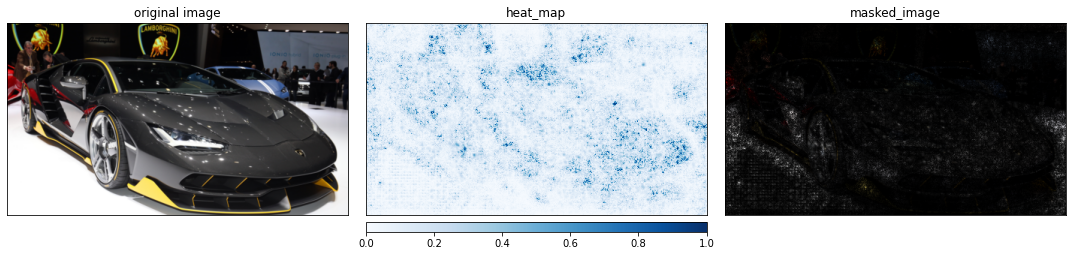

In [163]:
saliency = Saliency(model)
attributions_saliency = saliency.attribute(input, target=pred_label_idx)
vis(attributions_saliency, transformed_img)

## Input X Gradient

some info

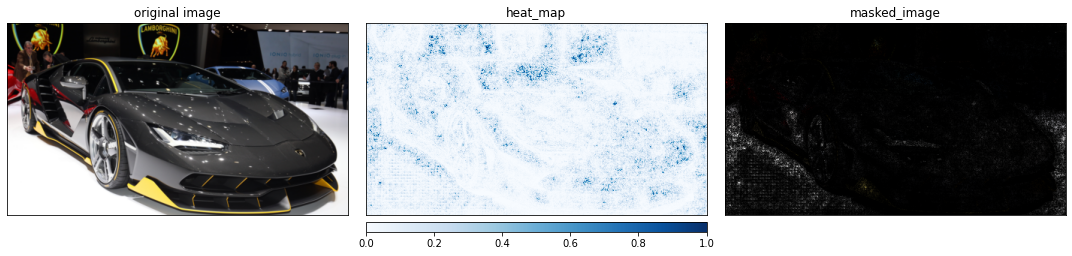

In [164]:
inputXgradient = InputXGradient(model)
attributions_inputXgradient = inputXgradient.attribute(input, target=pred_label_idx)
vis(attributions_inputXgradient, transformed_img)

## Guided Backpropagation

some info

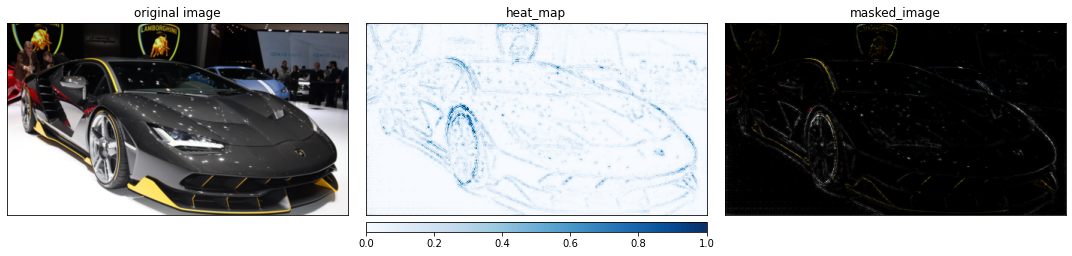

In [165]:
guided_backprop = GuidedBackprop(model)
attributions_guided_backprop = guided_backprop.attribute(input, target=pred_label_idx)
vis(attributions_guided_backprop, transformed_img)

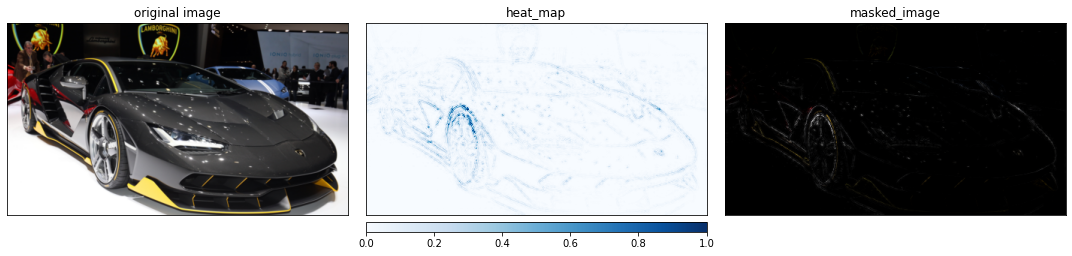

In [166]:
guided_gradcam = GuidedGradCam(model, model.layer4)
attributions_guided_gradcam = guided_gradcam.attribute(input, target=pred_label_idx)
vis(attributions_guided_gradcam, transformed_img)

# Perturbation-Based methods

## Occlusion 

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via sliding_window_shapes) with a stride of 8 along both image dimensions (a defined via strides). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via baselines).

Note: this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [189]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 40, 40),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3, 60, 60),
                                       baselines=0)

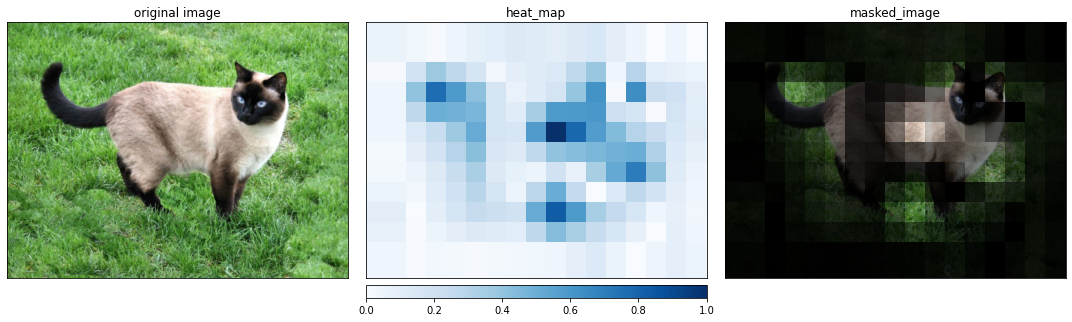

In [190]:
vis(attributions_occ, transformed_img)
